In [2]:
import spdcalc as spdc
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from numba import jit
import warnings
warnings.filterwarnings('ignore')

When calculating the two-source Hong-Ou-Mandel graph, we consider four photons from two identical crystals, i.e. two signal photons and two idler photons. The relevant integral to compute is

$$ \int\limits_{\omega_s} \int\limits_{\omega_i} \int\limits_{\omega_s'} \int\limits_{\omega_i'} \psi(\omega_s, \omega_i, \omega_s',\ \omega_i') - e^{i\phi}\psi(\omega_s', \omega_i, \omega_s,\ \omega_i')\ d\omega_i'\ d\omega_s'\ d\omega_i\ d\omega_s. $$ 

The wave function $\psi$ is equivalent to the joint spectral amplitude (JSA) for all four photons. Since the photons come from two separate sources, this joint amplitude is seprarble into two parts, so that 

$$ \psi(\omega_s, \omega_i, \omega_s',\ \omega_i') = \textrm{JSA}_1(\omega_s, \omega_i)\otimes \textrm{JSA}_2(\omega_s', \omega_i'). $$ 

Since the two sources are identical, we conclude that $\textrm{JSA}_1=\textrm{JSA}_2$. So we only need to compute the JSA once and then simply reference different indices for the different signal and idler photons. Using this notation, the integrand becomes

$$ \textrm{JSA}(\omega_s, \omega_i)\otimes \textrm{JSA}(\omega_s', \omega_i') - e^{i\phi}\textrm{JSA}(\omega_s', \omega_i)\otimes \textrm{JSA}(\omega_s, \omega_i'). $$ 

To compute the JSA matrix, we iterate over two for loops to construct a two-dimensional array of values.

In [3]:
lambda_s = lambda_i = 1550e-9
lambda_p = 775e-9
theta = np.radians(51.765)
dt = 1e-15
c = 3e8

setup = spdc.SPDCSetup.from_dict({
    "crystal": "KDP_1",
    "signal_wavelength": 1550e-9,
    "crystal_theta": np.radians(90), "pm_type": "Type2_e_eo",
    "pump_wavelength": 775e-9
}, with_defaults=True)
setup.assign_optimum_periodic_poling()

dim = 20
ranges = spdc.plotting.calc_plot_config_for_jsi(setup, dim)
x=ranges.get_x_values()
y=ranges.get_y_values()

signal = np.array(x)
idler = np.array(y)

JSA = np.zeros((dim, dim), dtype = np.csingle)

for i in range(dim):
    for j in range(dim):
        JSA[i][j] = spdc.jsa.calc_jsa(setup, signal[i], idler[j])

Performing this calculation in Python, we can simply iterate over many sums rather than explicitly calculating this integral. The variable $phi$ depends on time and wavelength difference between two photons of interest. For signal-signal interference, $\phi_{ss} = 2\pi\Delta t(\frac{1}{\lambda_s}-\frac{1}{\lambda_i})$. For idler-idler interference, $\phi_{ii} = 2\pi\Delta t(\frac{1}{\lambda_s'}-\frac{1}{\lambda_i'})$. For signal-idler interference, $\phi_{si}=2\pi\Delta t(\frac{1}{\lambda_s}-\frac{1}{\lambda_i'})$.

In the code, we let A, B, C, D stand for the different JSA configurations, between $\omega_s$ and $\omega_i$, $\omega_s'$ and $\omega_i'$, $\omega_s'$ and $\omega_i$, and $\omega_s$ and $\omega_i'$ respectively. 

In [4]:
@jit
def two_source_HOM(signal, idler, dt, JSA):
    rate_ss = 0
    rate_ii = 0
    rate_si = 0
    
    im = 1j
    
    const = 2*pi*c*dt
    for j in range(len(signal)): # signal 1
        s_j_inv = 1/signal[j]
        
        for k in range(len(idler)): # idler 1
            A = JSA[j][k]
            
            s_k_inv = 1/signal[k]
            for l in range(len(signal)): # signal 2
                C = JSA[l][k]
                
                i_l_inv = 1/idler[l]
                ARG_ss = const*(s_j_inv - i_l_inv)
                phase_ss = np.exp(im*ARG_ss)
                for m in range(len(idler)): # idler 2
                    i_m_inv = 1/idler[m]
                    
                    ARG_ii = const*(s_k_inv - i_m_inv)
                    phase_ii = np.exp(im*ARG_ii)
                    
                    ARG_si = const*(s_j_inv - i_m_inv)
                    phase_si = np.exp(im*ARG_si)
                    
                    B = JSA[l][m]
                    D = JSA[j][m]
                    
                    arg1 = A*B
                    arg2 = C*D
                    
                    intf_ss = (arg1 - phase_ss*arg2)*0.5
                    intf_ii = (arg1 - phase_ii*arg2)*0.5
                    intf_si = (arg1 - phase_si*arg2)*0.5
                    
                    rate_ss += np.absolute(intf_ss)**2
                    rate_ii += np.absolute(intf_ii)**2
                    rate_si += np.absolute(intf_si)**2
    return {'ss': rate_ss, 'ii': rate_ii, 'si': rate_si}

Next, we construct a normalization value by calculating the two-source Hong-Ou-Mandel for an extremely long time delay of 1 million seconds. At this point, we can assume that the coincidence probability will be very close to 0.5.

In [5]:
def two_source_HOM_norm(signal, idler, JSA):
    rate = 0
    for j in range(len(signal)):
        
        for k in range(len(idler)):
            A = JSA[j][k]
            
            for l in range(len(signal)):
                
                for m in range(len(idler)):
                    B = JSA[l][m]
                    
                    arg1 = A*B 
                    
                    rate += np.absolute(arg1)**2
    return rate

The next step is to construct a function that executes two_source_HOM over a range of time values in order to plot it. 

In [6]:
def two_source_HOM_range(signal, idler, times, JSA):
    norm = two_source_HOM_norm(signal, idler, JSA)
    rates = two_source_HOM(signal, idler, times, JSA)
    rate_ss = np.array(rates['ss'])
    rate_ii = np.array(rates['ii'])
    rate_si = np.array(rates['si'])
    rate_ss = rate_ss/norm
    rate_ii = rate_ii/norm
    rate_si = rate_si/norm
    return {"ss": rate_ss, "ii": rate_ii, "si": rate_si}

With this function, we can plot the signal-signal and idler-idler coincidence probabilities against $\Delta t$. 

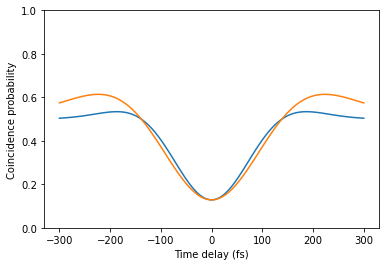

In [7]:
dimt = 100
times = np.linspace(-300e-15, 300e-15, dimt)
rates = two_source_HOM_range(signal, idler, times, JSA)
ss = rates['ss']
ii = rates['ii']

plt.plot(times*1e15, ss)
plt.plot(times*1e15, ii)
plt.ylabel('Coincidence probability')
plt.xlabel('Time delay (fs)')
plt.ylim(0,1)
plt.show()